## 1 特征选择 (feature_selection)
---
这里我们继续沿用Titanic数据集，这次侧重于对**模型的区分能力贡献最大**的几个特征选取的问题。
* 不良的特征会对模型的精度**“拖后腿”**
* 冗余的特征虽然不会影响模型的精度，不过CPU计算做了无用功。

我个人理解，这种特征选择与PCA这类特征压缩选择主成分的略有区别：**PCA重建之后的特征我们已经无法解释其意义了。**

In [1]:
#  这部分代码和前面说的有相同的效果，但是充分利用pandas会表达地更加简洁
import pandas as pd
import numpy as np

titanic = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')

print(titanic.info())
titanic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 11 columns):
row.names    1313 non-null int64
pclass       1313 non-null object
survived     1313 non-null int64
name         1313 non-null object
age          633 non-null float64
embarked     821 non-null object
home.dest    754 non-null object
room         77 non-null object
ticket       69 non-null object
boat         347 non-null object
sex          1313 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 112.9+ KB
None


,row.names,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,sex
0,1,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,2,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,3,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,(135),male
3,4,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,5,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male


In [2]:
# 我们丢掉一些过于特异的，不利于找到共同点的数据列（row.names,name），同时分离出预测列

y = titanic['survived']
X = titanic.drop(['row.names','name','survived'],axis = 1)# 删除列（axis = 1）

In [4]:
# 对于不连续的数值特征，我们采用补完的方式
X['age'].fillna(X['age'].mean(),inplace = True)# 年龄用平均值代替

X.fillna('UNKNOWN',inplace = True)# 其他空值用UNKNOW代替

In [8]:
X.head()

,pclass,age,embarked,home.dest,room,ticket,boat,sex
0,1st,29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,UNKNOWN,UNKNOWN,female
2,1st,30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,UNKNOWN,(135),male
3,1st,25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,UNKNOWN,UNKNOWN,female
4,1st,0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,UNKNOWN,11,male


In [9]:
# 剩下的类别类型数据，我们直接向量化，这样的话，对于有空白特征的列，我们也单独视为一个特征

from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 33)

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X_train = vec.fit_transform(X_train.to_dict(orient = 'record'))
X_test = vec.transform(X_test.to_dict(orient = 'record'))

In [10]:
print(len(vec.feature_names_))

474


In [13]:
X_train.toarray()

array([[ 31.19418104,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 31.19418104,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 31.19418104,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       ..., 
       [ 12.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 18.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 31.19418104,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ]])

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(X_train,y_train)
dt.score(X_test,y_test)
# 采用所有特征的测试精度

0.81155015197568392

In [15]:
from sklearn import feature_selection
# 基于卡方检验的特征选择
# https://blog.csdn.net/shuzfan/article/details/52993427
fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile = 20)

X_train_fs = fs.fit_transform(X_train,y_train)
dt.fit(X_train_fs,y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs,y_test)
# 采用20% 高预测性特征的测试精度

0.81458966565349544

In [36]:
from sklearn.cross_validation import cross_val_score
percentilts = range(1,100,2)# 选取从0-100% 按卡方检验选择特征

results = []

for i in percentilts:
    fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile = i)
    X_train_fs = fs.fit_transform(X_train,y_train)
    scores = cross_val_score(dt,X_train_fs,y_train,cv = 5)# 五折交叉验证
    results = np.append(results,scores.mean())# 将5折交叉验证集取平均 存取
print(results)

[ 0.85063904  0.85673057  0.87501546  0.88622964  0.86998557  0.87099567
  0.87099567  0.87404659  0.86589363  0.87098536  0.86389404  0.86692435
  0.86897547  0.86591424  0.86385281  0.86284271  0.8618223   0.86791383
  0.86791383  0.86590394  0.86386312  0.86995465  0.86894455  0.86590394
  0.86588332  0.87099567  0.86589363  0.86385281  0.85978149  0.86996496
  0.86996496  0.86997526  0.86691404  0.87402597  0.87404659  0.86589363
  0.87096475  0.87198516  0.86385281  0.87096475  0.87199546  0.86792414
  0.86183261  0.86589363  0.86795506  0.86487322  0.86082251  0.85877139
  0.86389404  0.85776129]


Optimal number of features [3]


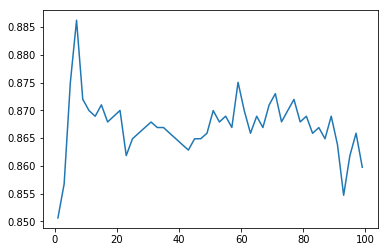

In [32]:
opt = np.where(results == results.max())[0] # 寻找最大值的索引值
print('Optimal number of features',opt)

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(percentilts,results)
plt.show()

In [34]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=opt)

X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)
# 选取搜索到的最好特征比例的测试精度

0.83282674772036469

In [37]:
# 由此可见，这个技术对于工程上提升精度还是非常有帮助的。